In [1]:
"""
Created By    : Lynnlee Rosolino
Creation Date : 30 September 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
Upper air observations were converted to polar coordinates and plotted on a polar
stereographic map

"""
__author__    = "Lynnlee Rosolino"
__contact__   = "lynnlee.rosolino@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
!pip install pandas
import pandas as pd                #pandas to spite jared

In [3]:
### Read in observations ###
data=pd.read_csv("RAOBs_201903131200.txt", delimiter=",",names=["station","lat","lon","500mbheight","500mbwinddir","500mbwindspeed"])
data[data.columns[1:5]]=data[data.columns[1:5]].astype(float) #numbers
#convert lat&lon to radians and add to data
data["lat_rad"]=data['lat']*(np.pi/180)
data["lon_rad"]=data['lon']*(np.pi/180)

#constants
mapproj=1/(15e6)
rho=6371*1e5
lambda0=-115
phi0=60*(np.pi/180)
f0=data["500mbheight"][roi_index] #heights in roi
f0=np.array(f0)

NameError: name 'roi_index' is not defined

In [ ]:
### Set up analysis map with a 22x28 rectangular grid of points ###
#find grid points, set up x-y grid
x_step=18.9+np.arange(22)*1.27
y_step=-6.3+np.arange(28)*1.27
x,y =np.meshgrid(x_step,y_step)

#transform equations into lat/lon
xlon=np.arctan(y/x)*(180/np.pi)+lambda0
ylat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x/mapproj)**2+(y/mapproj)**2)/(rho*(1+np.sin(phi0))))))

#plot to confirm i'm not stupid
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(xlon,ylat,transform=ccrs.PlateCarree(),marker="*",color="red")

NameError: name 'xlon' is not defined

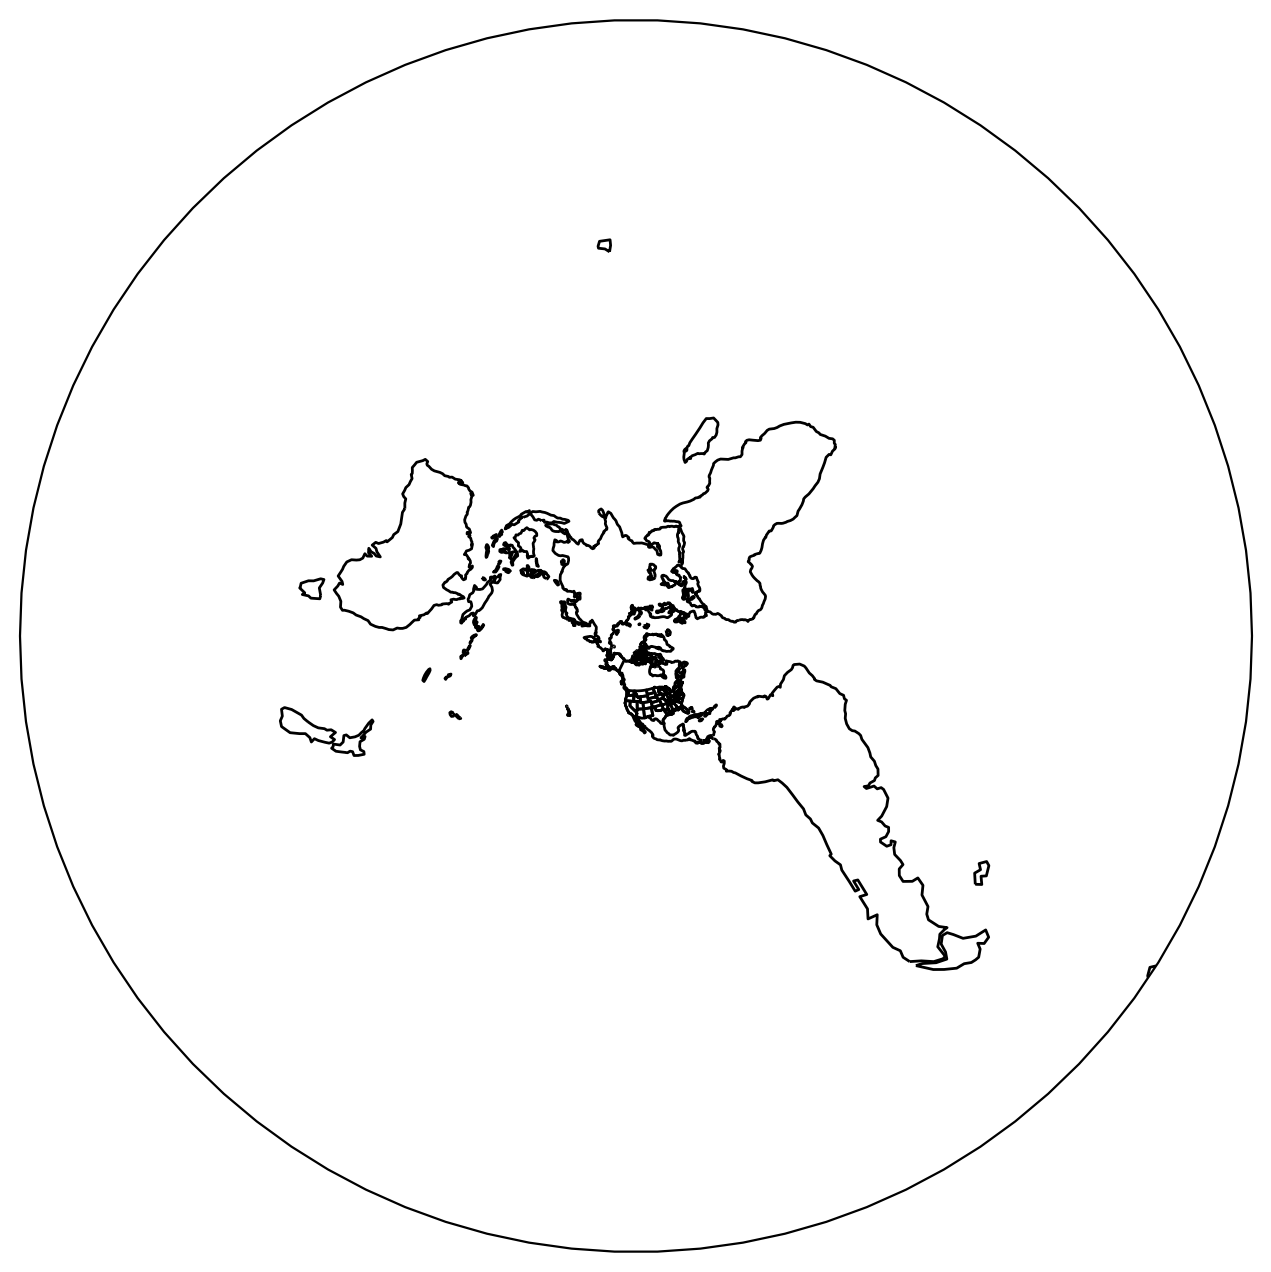

In [4]:
### convert obs lat/long to x,y ###

#assign vars
phi=data["lat_rad"]
lambdy=data["lon_rad"]

#solve for image scale factor
sigma=(1+np.sin(phi0))/(1+np.sin(phi))

#solve radius of lat circle
r=rho*sigma*np.cos(phi)

#deviation of lon from standard
dev=lambdy-(lambda0*np.pi/180)
xdev=r*np.cos(dev)*mapproj
ydev=r*np.sin(dev)*mapproj

#convert to array
xdev=np.array(xdev)
ydev=np.array(ydev)

#convert back to lat/lon
data_lon=np.arctan(ydev/xdev)*(180/np.pi)+lambda0
data_lat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((xdev/mapproj)**2+(ydev/mapproj)**2)/(rho*(1+np.sin(phi0))))))

#plot to confirm i'm not stupid
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(xlon,ylat,transform=ccrs.PlateCarree(),marker="*",color="red")
ax1.scatter(data_lon,data_lat,transform=ccrs.PlateCarree())


In [6]:
xdev

NameError: name 'xdev' is not defined

In [35]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###
yrow=22
xcol=28

#roi array
roiarray=np.array([10,20])

#make empty obs and analysis matrices
obsmat=np.zeros((28,22,len(roiarray)))
analmat=np.zeros((28,22,len(roiarray)))

#feelin loopy after writin this loop
for i in range(len(roiarray)):
    roi=roiarray[i]
    for j in range(len(x)):
        for k in range(len(x[0])):
            xs=x[j,k]-xdev   #grid point - loc of obs
            ys=y[j,k]-ydev   #grid point - loc of obs
            radius=((xs**2)+(ys**2))**(1/2)  #distance formula
            #make sure obs are in roi
            roi_index=np.where(radius<=roi)[0]
            #make obs matrix same size and shape as obs in roi
            obsmat[j,k,i]=len(roi_index)
            
            #create matrices for f0(x,y)
            xk=xs[roi_index] #x values in roi
            yk=ys[roi_index] #y values in roi
            f0=data["500mbheight"][roi_index] #heights in roi
            f0=np.array(f0)
            
            #arrays for that annoying matrix
            R=np.zeros((6,6))
            O=np.zeros(6)
            
            #populate R matrix
            for q in range(len(yk)):
                r2=np.matrix([1.,xk[q],yk[q],xk[q]**2,yk[q]**2,xk[q]*yk[q]])
                #transform of r1=r2
                r1=r2.T
                #multiply r1 and r2 to get R array
                rr=r1*r2
                R+=np.array(rr)
                #populate O matrix
                O+=np.array([f0[q],xk[q]*f0[q],yk[q]*f0[q],xk[q]**2*f0[q],yk[q]**2*f0[q],xk[q]*yk[q]*f0[q]])
                
            #calculate average values by dividing by #of obs
            #this line had an issue. ittook 5 hours to resolve. turns out I'm stupid, sorry for the inconvenience#
            R=R/obsmat[j,k,i]
            O=O/obsmat[j,k,i]
                
            #calculate C
            C=np.linalg.inv(np.matrix(R))*np.matrix(O).T
            #C00 is the only variable we care about
            analmat[j,k,i]=C[0,0]

[[1.00000000e+00 7.76485650e+00 8.03554096e+00 9.70942258e+01
  1.18656377e+02 5.86380387e+01]
 [7.76485650e+00 9.70942258e+01 5.86380387e+01 1.18389443e+03
  7.57872245e+02 6.38956402e+02]
 [8.03554096e+00 5.86380387e+01 1.18656377e+02 6.38956402e+02
  1.42118625e+03 7.57872245e+02]
 [9.70942258e+01 1.18389443e+03 6.38956402e+02 1.79343489e+04
  8.10836084e+03 7.73583688e+03]
 [1.18656377e+02 7.57872245e+02 1.42118625e+03 8.10836084e+03
  2.39653213e+04 8.43567368e+03]
 [5.86380387e+01 6.38956402e+02 7.57872245e+02 7.73583688e+03
  8.43567368e+03 8.10836084e+03]]


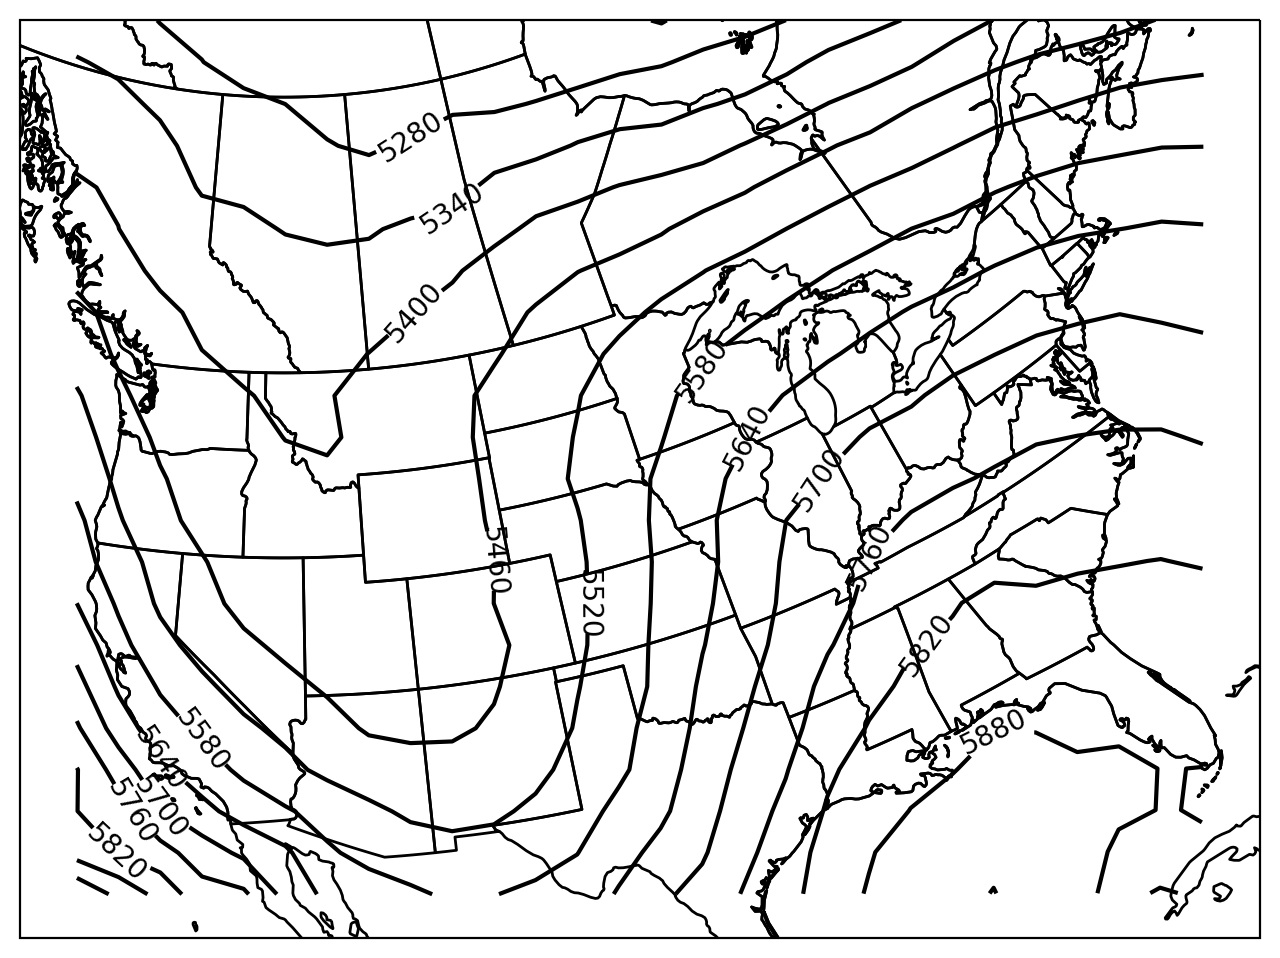

In [40]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,analmat[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
#plt.savefig('10cmroi_analysis.png')
#plt.savefig('20cmroi_analysis.png')
plt.show()


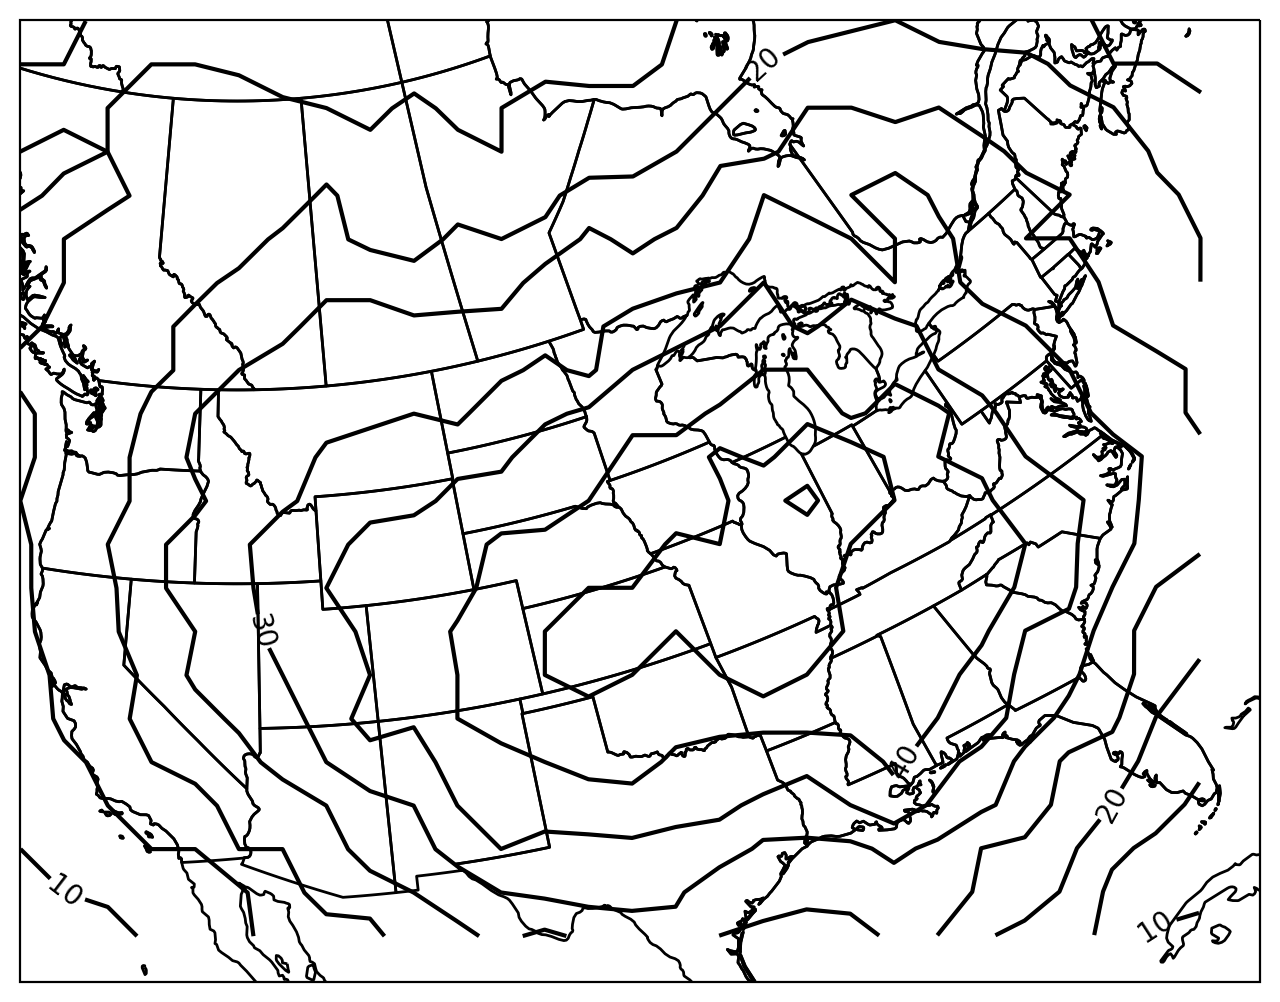

In [43]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(xlon,ylat,obsmat[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.savefig('10cmroi_observation.png')
#plt.savefig('20cmroi_observation.png')
plt.show()

In [29]:
### Store the analyses in text files ###
analysis_file=open("analysis_file.txt","w+")
analysis=str(analmat)
analysis_file.write(analysis)
analysis_file.close()


In [30]:
### Store the number of observations available for each grid point in text files ###
observation_file=open("observation_file.txt","w+")
obs=str(obsmat)
observation_file.write(obs)
observation_file.close()


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

        There is a prominent 500mb trough in the Rockies and 500mb ridge in the Eastern United States on 
        both maps. There is also a shortwave trough in Alberta/Saskatchewan Canada. This shortwave dips 
        all the way into Montana on the 10cm analysis map.
        
2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
        The 20cm radius of influence analysis map contours seem to be smoother than the 10 cm radius of
        influence analysis map. This is because there are more observations which are able to be included
        so the function is smoother.
    

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
        The results do not look realistic. Contours below 5400 and above 5820 are very close together
        indicating a gradient that is much tighter than it would ever realistically be. This is 
        likely due to a lack of observations within the indicated radius of influence, thus creating
        too many contours.
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
        No, if only one observation was obtained the matrix would be populated with ones. 
        The determinant of this matrix would therefore be zero which makes the matrix
        non-invertable. 
    

'''